# Kita Pisahkan datanya menjadi 3
1. train (data latih)
2. validation (validasi untuk data latih)
3. test (data testing untuk menguji model)

In [1]:
import os

# Membuat Classifier nya

In [2]:
import tensorflow as tf

Dibagian ini kita akan menentukan seberapa banyak jumlah epoch untuk proses training, input dimension, batch_size. dll

In [3]:
# Define Input Parameters
dim = (150, 150)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

# Mempersiapkan dataset pipeline dan augmentation Untuk proses pembuatan dataset

Dataset pipeline merupakan perintah untuk melakukan ekstraksi data yang berupa images/citra digital, yang berasal dari sebuah folder menjadi sebuah array yang dapat dibaca oleh tensorflow

## Membuat dataset generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Fungsi tersebut merupakan Image data generator sehingga kita mengenerate data image dari sebuah file / folder yang telah kita buat sebelumnya. pada bagian ini kita dapat menentukan generator / augmentasi seperti apa yang dapat dilakukan.

## Mendefinisikan data generator nya

Pertama tama kita mendefinisikan terlebih dahulu bagaimana transformasi data yang akan digunakan.

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

Pada perintah diatas kita melakukan
1. Rescaling data menjadi 1/255.
2. Shearing image skala 0.2
3. Zooming image dengan range 0.2
4. dan melakukan Horizontal flip

## Mendefinisikan asal folder sumber file berasal

Setelah mendefinisikan generatornya, selanjutnya kita mendefinisikan darimana sumber datanya berasal. Misalkan pada project kali ini kita menggunakan data yang berasal dari folder (dictionary)

In [6]:
train_generator = train_datagen.flow_from_directory('D:/dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('D:/dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('D:/dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 3465 images belonging to 5 classes.
Found 425 images belonging to 5 classes.
Found 433 images belonging to 5 classes.


pada code diatas, kita menggunakan flow from dir dimana fungsi tersebut mengarahkan kita kepada folder set yang telah kita buat sebelumnya. di mana :
1. target size = dimensi dari citra yang akan digunakan dalam proses training
2. batch size = banyaknya citra yang dimasukan dalam setiap steps training.
3. class mode = metode pemilihan klasifikasi
4. shuffle = data didalam folder tersebut diacak sehingga tidak sesuai urutan yang ada seperti urutan alfabetik.

In [7]:
print(labels)

dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [8]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

Pada proses ini kita akan melakukan transformasi variabel train_generator dan lainnya menjadi tf data, kenapa menggunakan tf.data karena tf.data merupakan tipe variabel generator yang cocok dengan tf.keras sehingga sangat optimal dalam pembacaan data yang dilakukan dalam proses training dibandingkan hanya menggunakan generator dari keras itu sendiri. 

In [9]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

# Membuat Struktur CNN

Setelah membuat dataset generator, selanjutnya kita melakukan membuat jaringan nerual network. Namun karena kita terlalu malas maka kita dapat menggunakan network yang sudah ada. pada project ini kita menggunakan Mobilenet V2

## Manualy define network

In [10]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

In [11]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      36896     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

Pertama-tama kita mendefinisikan terlebih dahulu base-model kita / yang akan di gunakan pada project ini.

# Using Pre-trained model / Transfer Learning

## Prebuild model

### Build Base Model

Setelah membuat dataset generator, selanjutnya kita melakukan membuat jaringan nerual network. Namun karena kita terlalu malas maka kita dapat menggunakan network yang sudah ada. pada project ini kita menggunakan Mobilenet V2

Pertama-tama kita mendefinisikan terlebih dahulu base-model kita / yang akan di gunakan pada project ini.

In [13]:
from tensorflow.keras.applications import MobileNetV2

# get base models
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

1. Input_shape = merupakan dimensi dari gambar yang akan kita gunakan/ input dari citra
2. Include top = adalah perintah untuk menyertakan apakah model yang digunakan akan disertakan dengan top layer dari arsitektur    network tersebut atau misalkan top network tersebut memiliki 3 node yaitu : flatten layer, layer dengan 1024 node dan fungsi    aktivasinya, lalu prediction node dimana jumlah node sesuai dengan banyaknya jumlah kelas.
   Dikarenakan jumlah kelas pada imagenet adalah 1000 maka ini tidak cocok dengan jumlah kelas yang kita miliki yaitu hanya 5.    sehingga include top di sini adalah false.
3. Weights = adalah bobot dari masing-masing layer yang sudah di training berdasarkan bobot imagenet. Kita juga bisa meniadakan    ini dengan menggunakan None Namun ketika tidak menggunakan pre-trained weight proses training kita akan lebih lama karena      initial value dari weight nya random sehingga perlu banyak penyesuaian terhadap data yang akan kita gunakan.
4. Classes = adalah jumlah class yang kita miliki

### Add top layer network

In [14]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [15]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [17]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Effinet

In [18]:
from efficientnet.tfkeras import EfficientNetB1

### Build Base model

In [19]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

### Add top network layer to models

In [20]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [21]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

Kita telah menambahkan top-layer kedalam network dan variabel yang digunakan adalah model. Kemudian kita dapat melihat keseluruhan network dengan menggunakan model.summary()


In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [23]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Visualize The final model

In [24]:
import tensorflow as tf

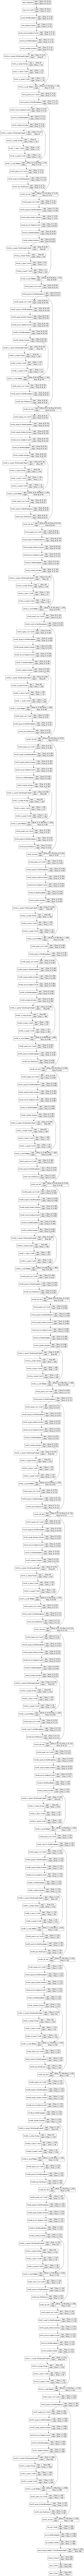

In [25]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

# Train Model

In [26]:
EPOCH = 50

In [27]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/50
217/217 [==============================] - 920s 4s/step - loss: 0.8774 - accuracy: 0.6800 - val_loss: 1.3044 - val_accuracy: 0.6988
Epoch 2/50
217/217 [==============================] - 647s 3s/step - loss: 0.4312 - accuracy: 0.8573 - val_loss: 0.8401 - val_accuracy: 0.7412
Epoch 3/50
217/217 [==============================] - 474s 2s/step - loss: 0.3940 - accuracy: 0.8652 - val_loss: 0.6084 - val_accuracy: 0.7882
Epoch 4/50
217/217 [==============================] - 474s 2s/step - loss: 0.3515 - accuracy: 0.8771 - val_loss: 0.7393 - val_accuracy: 0.7765
Epoch 5/50
217/217 [==============================] - 473s 2s/step - loss: 0.2676 - accuracy: 0.9066 - val_loss: 0.7300 - val_accuracy: 0.7553
Epoch 6/50
217/217 [==============================] - 473s 2s/step - loss: 0.2540 - accuracy: 0.9210 - val_loss: 0.7108 - val_accuracy: 0.8118
Epoch 7/50
217/217 [==============================] - 473s 2s/step - loss: 0.2210 - accuracy: 0.9287 - val_loss: 0.8874 - val_accuracy: 0.7035

In [28]:
history.history['loss']

[0.7141357064247131,
 0.44024917483329773,
 0.41872742772102356,
 0.3552533984184265,
 0.296080082654953,
 0.2695530354976654,
 0.22447586059570312,
 0.23730020225048065,
 0.19753700494766235,
 0.20904125273227692,
 0.16739067435264587,
 0.19359174370765686,
 0.15543726086616516,
 0.16150057315826416,
 0.14532898366451263,
 0.14653968811035156,
 0.11992114037275314,
 0.14364714920520782,
 0.10537179559469223,
 0.12296280264854431,
 0.10034412890672684,
 0.08444547653198242,
 0.11019410192966461,
 0.11539793014526367,
 0.09930361062288284,
 0.09182681888341904,
 0.09716811031103134,
 0.09356600791215897,
 0.1018308699131012,
 0.10160002112388611,
 0.08134502172470093,
 0.05662231892347336,
 0.09234591573476791,
 0.10169919580221176,
 0.07745884358882904,
 0.06383994966745377,
 0.07027953118085861,
 0.07615043222904205,
 0.10144048184156418,
 0.07752152532339096,
 0.08100070804357529,
 0.06301389634609222,
 0.053628090769052505,
 0.05669518932700157,
 0.06484377384185791,
 0.075468130409

In [29]:
history.history['accuracy']

[0.7515151500701904,
 0.8513708710670471,
 0.860028862953186,
 0.8802309036254883,
 0.9038960933685303,
 0.9096680879592896,
 0.9261183142662048,
 0.9142857193946838,
 0.9321789145469666,
 0.9292929172515869,
 0.9463203549385071,
 0.9388167262077332,
 0.9466089606285095,
 0.9474747180938721,
 0.9520923495292664,
 0.9503607749938965,
 0.958730161190033,
 0.9535353779792786,
 0.9621933698654175,
 0.9621933698654175,
 0.9691197872161865,
 0.9734487533569336,
 0.9653679728507996,
 0.9595959782600403,
 0.9682539701461792,
 0.9708513617515564,
 0.9685425758361816,
 0.9688311815261841,
 0.9653679728507996,
 0.9670995473861694,
 0.9754689931869507,
 0.9821068048477173,
 0.973737359046936,
 0.965656578540802,
 0.9746031761169434,
 0.9795093536376953,
 0.9780663847923279,
 0.9763347506523132,
 0.9699855446815491,
 0.9743145704269409,
 0.973737359046936,
 0.9783549904823303,
 0.9826839566230774,
 0.9832611680030823,
 0.9763347506523132,
 0.9748917818069458,
 0.9821068048477173,
 0.980086565017700

# Plot the training

In [30]:
from matplotlib import pyplot as plt

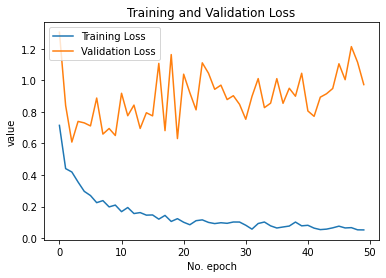

In [31]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

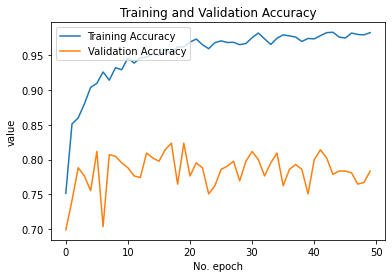

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [33]:
import os

In [34]:
MODEL_BASE_PATH = "D:\model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)    
    

Saving Model At D:\model\medium_project\model.h5...


# Evaluate Model

In [35]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.9053 
Loss on training data: 0.3991 

Accuracy on test data: 0.8891 
Loss on test data: 0.4319 



# Membuat fungsi Prediksi

In [36]:
import requests
from io import BytesIO

from PIL import Image
import numpy as np

# Membuat Function

In [37]:
# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [38]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [39]:
from tensorflow.keras.models import load_model

# Load Model

In [40]:
# ada 2 cara load model, jika cara pertama berhasil maka bisa lasngusng di lanjutkan ke fungsi prediksi

MODEL_PATH = 'D:/model/medium_project/model.h5'
model = load_model(MODEL_PATH,compile=False)

# Predict the Image

In [41]:
# read image
im = Image.open('D:/tulip.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

tulip 0.9999008
